In [0]:
import fastai2
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path("/content/gdrive/My Drive/")
# base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [0]:
_default_meta    = {'cut':None, 'split':default_split}

In [0]:
def unet_learner(dbunch, arch, loss_func=None, pretrained=True, cut=None, splitter=None, config=None, **kwargs):
    print('new')
    "Build a unet learner from `dbunch` and `arch`"
    if config is None: config = {}
    meta = model_meta.get(arch, _default_meta)
    body = create_body(arch, pretrained, ifnone(cut, meta['cut']))
    size = dbunch.one_batch()[0].shape[-2:]
    model = DynamicUnet(body, get_c(dbunch), size, **config)
    learn = Learner(dbunch, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

## Data

In [0]:
# path = Path('/home/jupyter/data/coco'); path.ls(), len(get_image_files(path))
# path = untar_data(URLs.COCO_SAMPLE)/'train_sample'; path.ls(), len(get_image_files(path))
path = Path('data')

In [0]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=lambda *a, **kw: get_image_files(*a, **kw),
                   splitter=RandomSplitter(0.1, seed=42),
                   get_y=lambda x: x,
                 )

In [0]:
bs, sz = 16, 256
dbch = dblock.databunch(path, bs=bs, item_tfms=[Resize(sz)], batch_tfms=[*aug_transforms(), Normalize(*imagenet_stats)])
dbch.c = 3

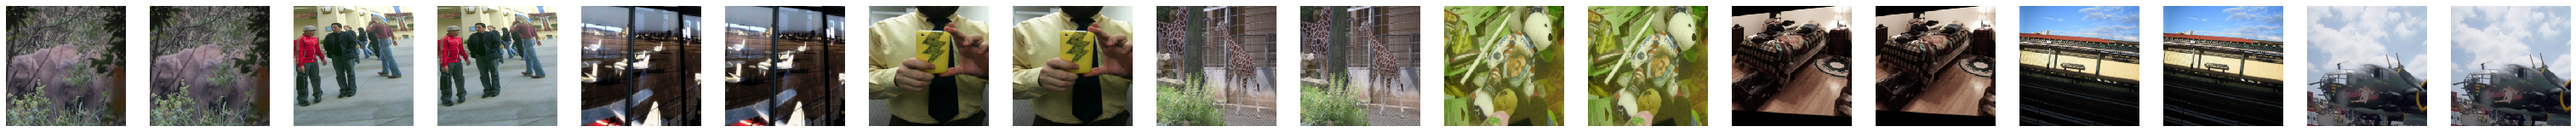

In [8]:
dbch.show_batch(rows=1)

In [9]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQu-5JDMsnkG2oqRnroxZI4HX-3A_HRd63_Hz_dEmX6RFW4Tm2n -O style.jpg

--2019-11-29 02:43:47--  https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQu-5JDMsnkG2oqRnroxZI4HX-3A_HRd63_Hz_dEmX6RFW4Tm2n
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 108.177.15.101, 108.177.15.138, 108.177.15.100, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|108.177.15.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40368 (39K) [image/jpeg]
Saving to: ‘style.jpg’

style.jpg           100%[===================>]  39.42K  --.-KB/s    in 0s      

2019-11-29 02:43:47 (120 MB/s) - ‘style.jpg’ saved [40368/40368]



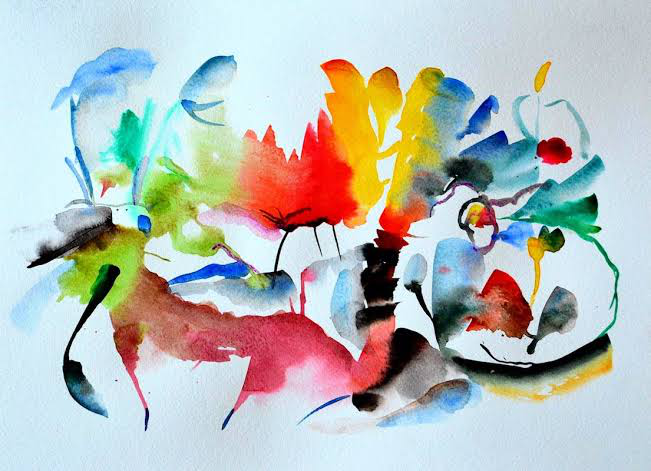

In [10]:
# How can I be sure this is working correctly?
fn = 'style.jpg'
pipe = Pipeline([PILImage.create, ToTensor(), IntToFloatTensor(), Normalize(*imagenet_stats, cuda=False)])
style_timg = TensorImage(pipe(fn).cuda());
PILImage.create(fn)

## Loss func

In [0]:
def gram(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [0]:
base_loss = F.l1_loss
class FSTLoss(nn.Module):
    def __init__(self, m_feat, cnt_ls, stl_ls, cnt_lsw, stl_lsw, stl_loss_mult=1e6):
        super().__init__()
        assert len(cnt_ls) == len(cnt_lsw)
        assert len(stl_ls) == len(stl_lsw)
        self.m_feat,self.cnt_ls,self.stl_ls,self.stl_loss_mult=m_feat,cnt_ls,stl_ls,stl_loss_mult
        self.cnt_lsw = tensor(cnt_lsw).float() / sum(cnt_lsw)
        self.stl_lsw = tensor(stl_lsw).float() / sum(stl_lsw)
        self.cnt_hooks = hook_outputs(cnt_ls, detach=False)
        self.stl_hooks = hook_outputs(stl_ls, detach=False)
        self.metric_names = ['style', 'content']
        # TODO: Temporary
        self.reset_metrics()
        
    def reset_metrics(self): self.metrics = dict(style=[], content=[])
        
    def register_style(self, timg):  _,self.stl_fs = self.get_fs(timg, True)

    def get_fs(self, x, clone=False):
        self.m_feat(x)
        cnt_fs = [(o.clone() if clone else o) for o in self.cnt_hooks.stored]
        stl_fs = [(o.clone() if clone else o) for o in self.stl_hooks.stored]
        return cnt_fs, stl_fs
    
    def forward(self, pred, targ, **kwargs):
        pred_cnt_fs, pred_stl_fs = self.get_fs(pred, True)
        targ_cnt_fs, targ_stl_fs = self.get_fs(targ)
        stl_loss = self.stl_loss_mult*self._stl_loss(pred_stl_fs)
        cnt_loss = self._cnt_loss(pred,targ,pred_cnt_fs,targ_cnt_fs)
        # self.metrics = dict(zip(self.metric_names, [stl_loss, cnt_loss]))
        self.metrics['style'].append(stl_loss); self.metrics['content'].append(cnt_loss)
        return stl_loss + cnt_loss
        
    def _stl_loss(self, pred_fs):
        stl_loss = [base_loss(gram(pred_f),gram(style_f))*w
                    for pred_f,style_f,w in zip(pred_fs,self.stl_fs,self.stl_lsw)]
        return sum(stl_loss)
    
    def _cnt_loss(self, pred, targ, pred_fs, targ_fs):
        cnt_loss =  [base_loss(pred,targ)]
        cnt_loss += [base_loss(pred_f,targ_f)*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        cnt_loss += [base_loss(gram(pred_f),gram(targ_f))*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        return sum(cnt_loss)

In [13]:
vgg_m = vgg16_bn(True).features.cuda().eval()
for p in vgg_m.parameters(): p.requires_grad = False
vgg_m.eval(); requires_grad(vgg_m)

False

In [0]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
bnecks = [vgg_m[i] for i in blocks]

In [0]:
fst_loss = FSTLoss(vgg_m, cnt_ls =bnecks[3:4], stl_ls= bnecks[1:],
                          cnt_lsw=[1]      , stl_lsw=[1, 1, 1, 1], stl_loss_mult=1e5)
fst_loss.register_style(style_timg)

In [0]:
opt_func = lambda ps, lr, **kwargs: Lookahead(RAdam(ps, lr, wd=1e-3, **kwargs))

## Transformer net

In [17]:
arch = partial(xresnet34, sa=True, norm_type=NormType.Instance)
config = unet_config(blur=True, self_attention=True, y_range=(-3, 3), norm_type=NormType.Instance)
learn = unet_learner(dbch, arch, loss_func=fst_loss, opt_func=opt_func, config=config, pretrained=False)

new


In [0]:
Conv = partial(ConvLayer, norm_type=NormType.Instance)
Res = partial(ResBlock, 1, norm_type=NormType.Instance, sa=True)
tn = nn.Sequential(
    Conv(3, 32, stride=2),
    Conv(32, 32, stride=1),
    Conv(32, 64, stride=1),
    Conv(64, 64, stride=2),
    Conv(64, 128, stride=2),
    Res(128, 128),
    Res(128, 128),
    Res(128, 128),
    Res(128, 128),
    Res(128, 128),
)
utn = DynamicUnet(tn, 3, (256, 256), norm_type=NormType.Instance, blur=True, self_attention=True, y_range=(-3, 3))

In [0]:
learn = Learner(dbch, m, loss_func=fst_loss, opt_func=opt_func)

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Annoying pytorch broadcast warning: (torch.Size([1, 512, 512])) that is different to the input size (torch.Size([32, 512, 512]))

In [0]:
learn.load('utn-cove-256')

In [20]:
learn.path = root_dir/'dl/style/watercolor'; learn.path

PosixPath('/content/gdrive/My Drive/dl/style/watercolor')

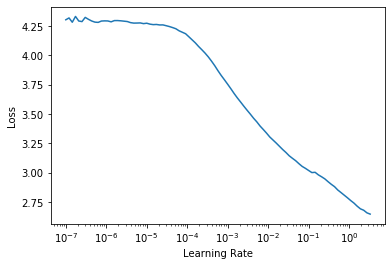

In [17]:
learn.lr_find()

In [0]:
# lr:1e-1   - 1.07
# lr:4e-2   - 1.037

In [21]:
learn.fit_flat_cos(1, 5e-2)

In [0]:
learn.save('res34-watercolor-256_1')

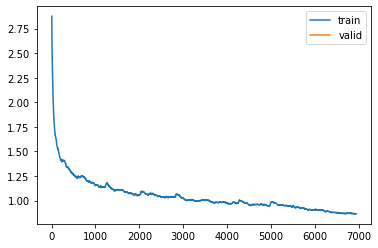

In [23]:
learn.recorder.plot_loss()

In [0]:
fst_loss.reset_metrics()

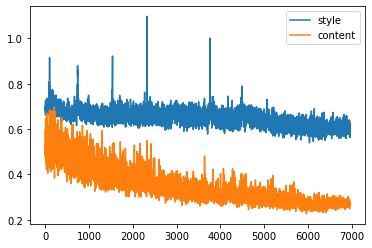

In [25]:
for n, v in fst_loss.metrics.items(): plt.plot(v[500:], label=n)
plt.legend()

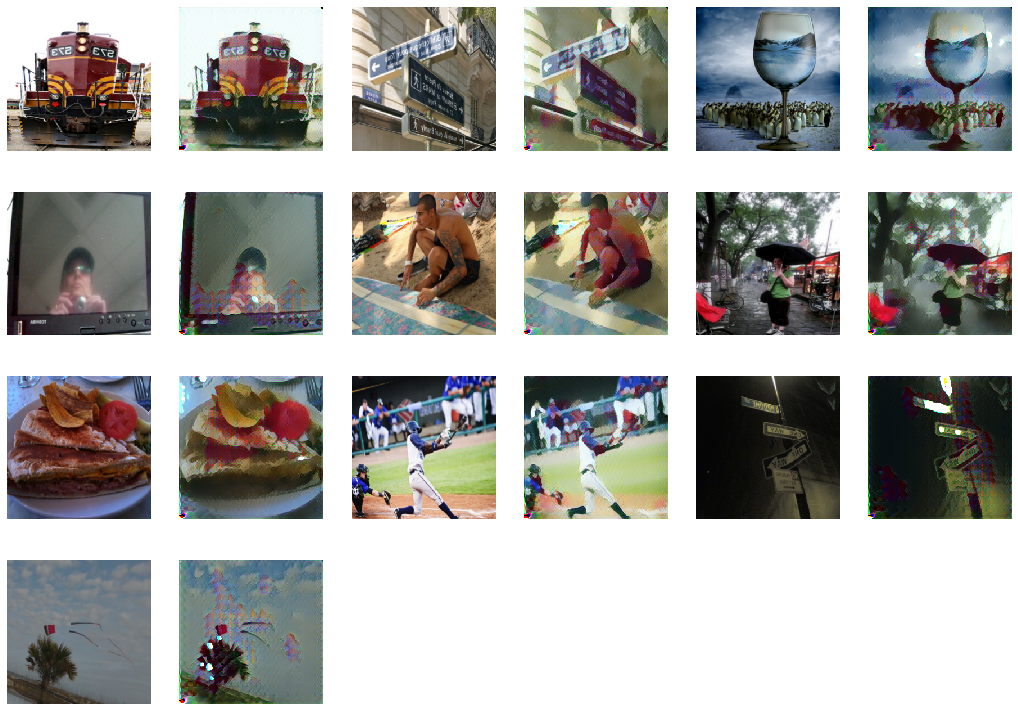

In [26]:
learn.show_results()

In [0]:
test_pipe = Pipeline([PILImage.create, ToTensor(), IntToFloatTensor(), Normalize(*imagenet_stats, cuda=False)])

In [28]:
!wget https://github.com/lgvaz/projects/blob/master/vision/style/tests/chicago.jpg?raw=true -O test.jpg

--2019-11-29 04:08:42--  https://github.com/lgvaz/projects/blob/master/vision/style/tests/chicago.jpg?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/lgvaz/projects/raw/master/vision/style/tests/chicago.jpg [following]
--2019-11-29 04:08:42--  https://github.com/lgvaz/projects/raw/master/vision/style/tests/chicago.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lgvaz/projects/master/vision/style/tests/chicago.jpg [following]
--2019-11-29 04:08:42--  https://raw.githubusercontent.com/lgvaz/projects/master/vision/style/tests/chicago.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:

In [0]:
timg = test_pipe('test.jpg').cuda()
pred = TensorImage(learn.model(timg)).cpu()

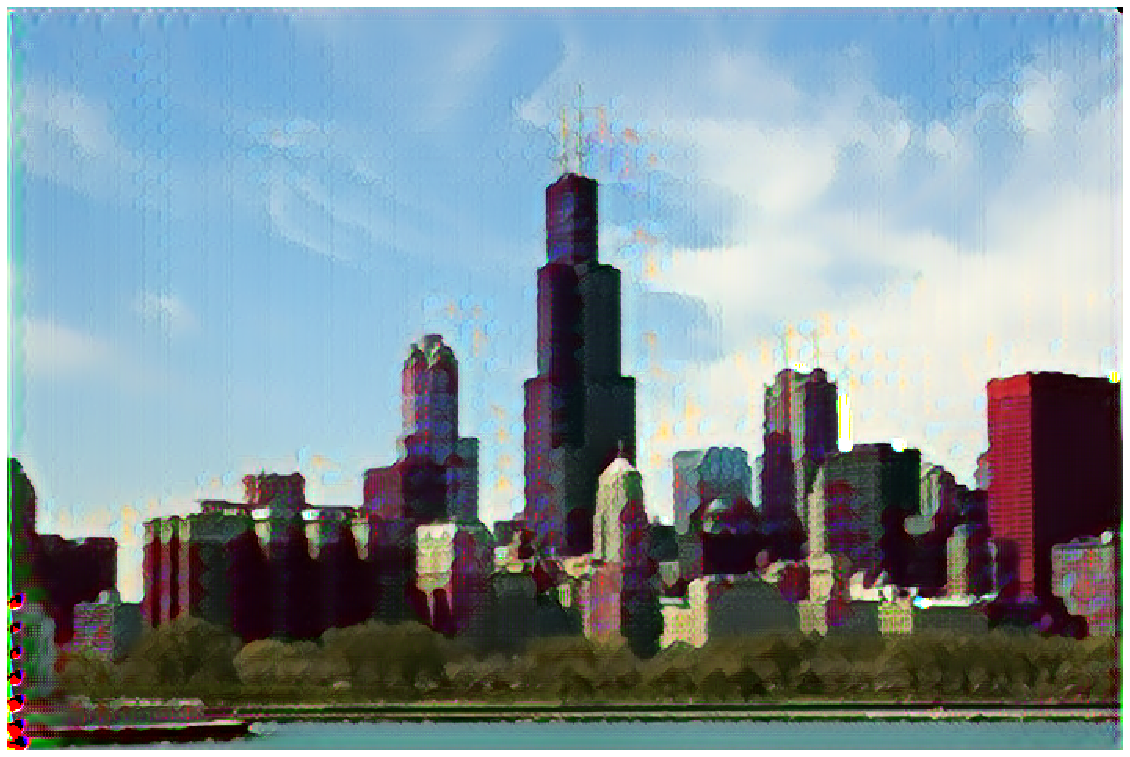

In [30]:
show_images(test_pipe.decode(pred), figsize=(20,20))

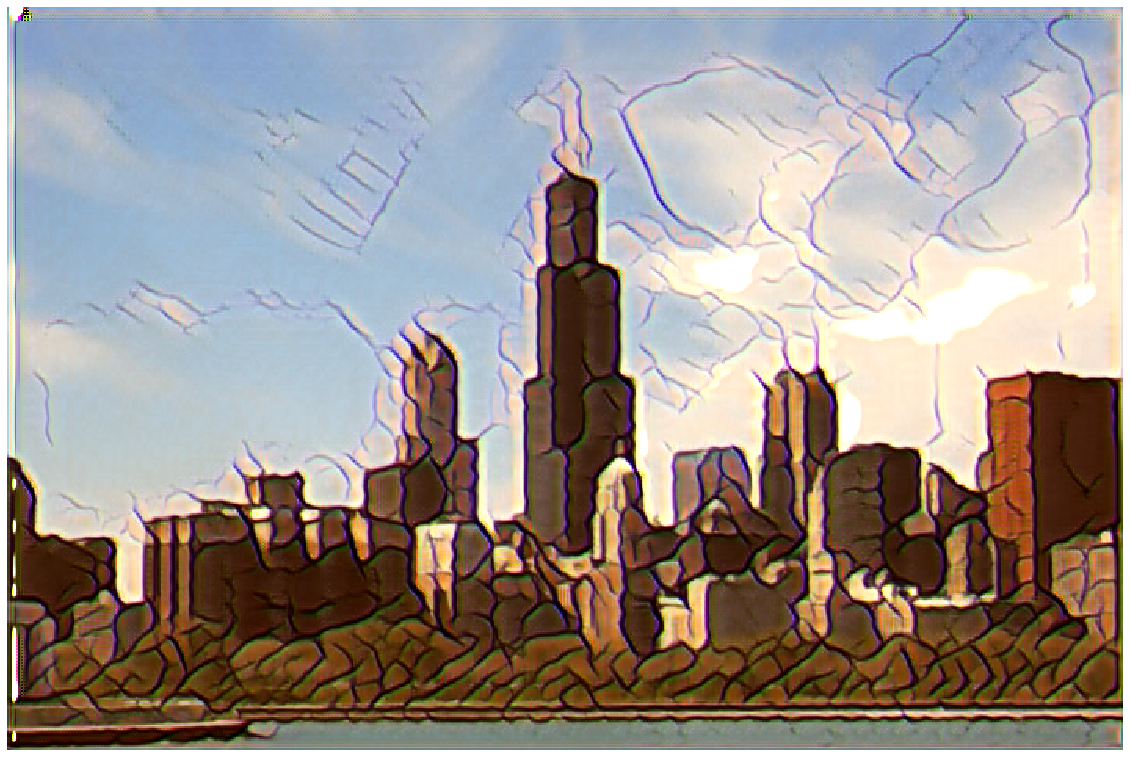

In [30]:
show_images(test_pipe.decode(pred), figsize=(20,20))

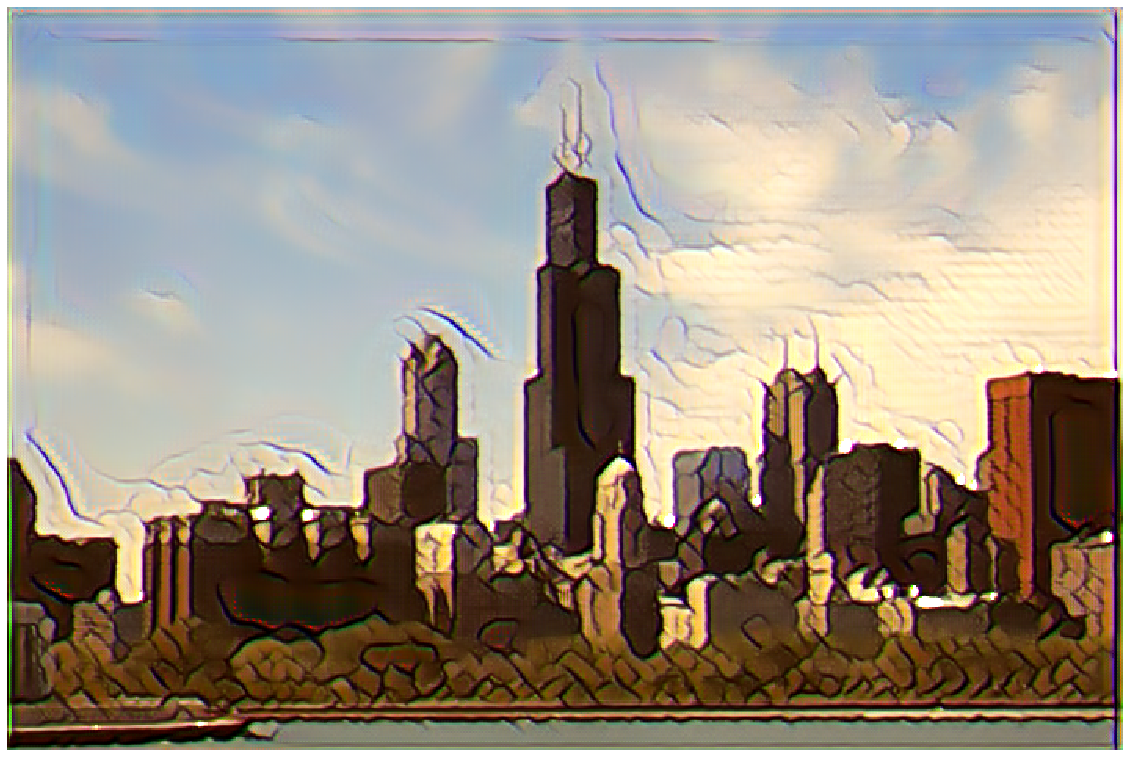

In [29]:
show_images(test_pipe.decode(pred), figsize=(20,20))

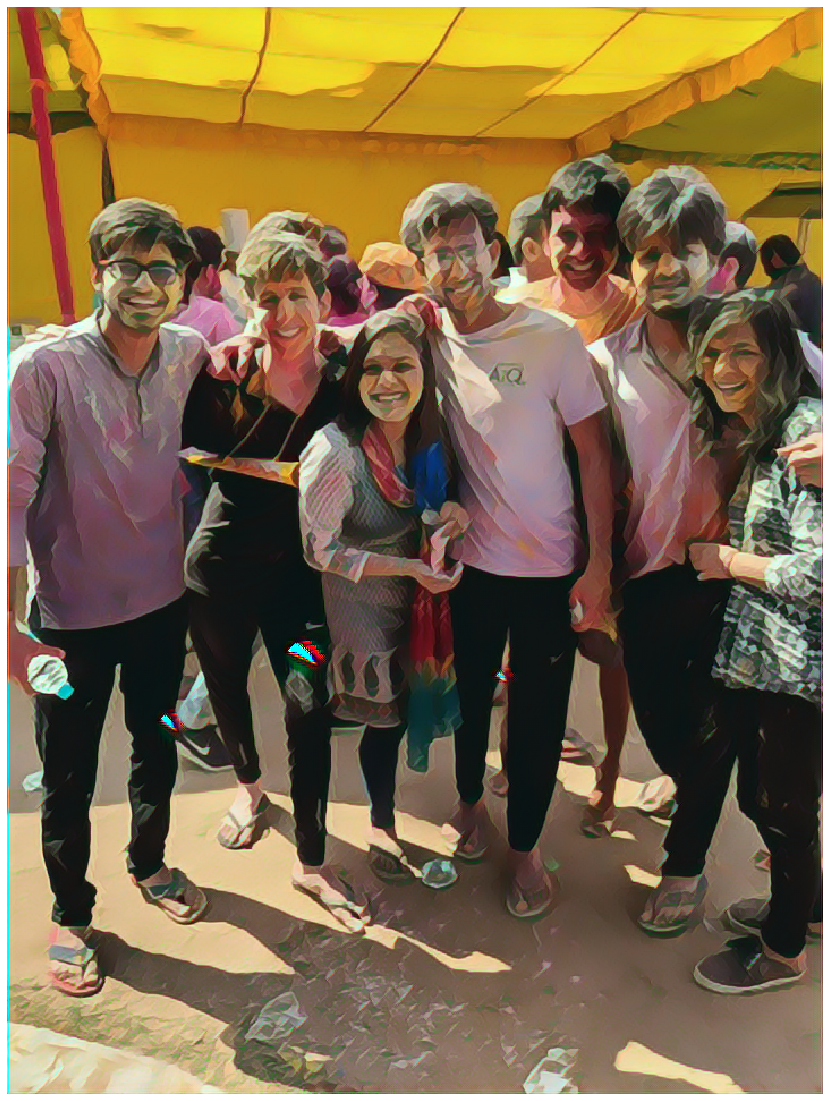

In [0]:
show_images(test_pipe.decode(pred), figsize=(20,20))

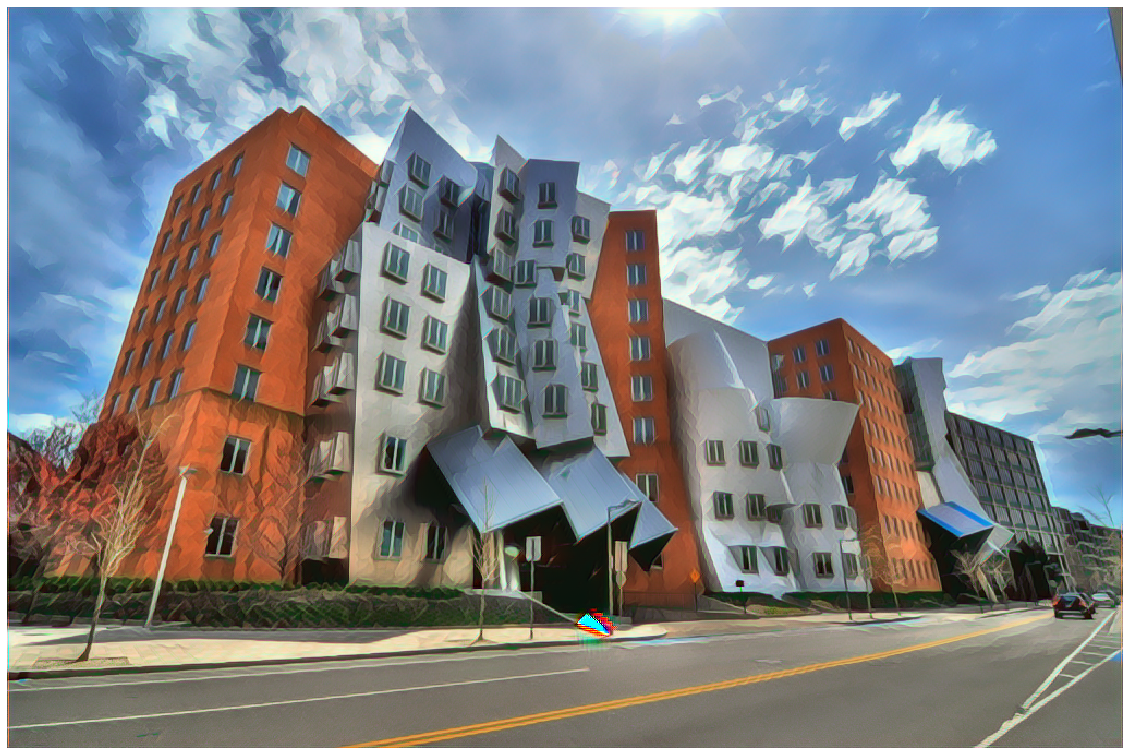

In [0]:
show_images(test_pipe.decode(pred), figsize=(20,20))